In [ ]:
! /anaconda/envs/py35/bin/python -m pip install azure-cognitiveservices-search-imagesearch

In [ ]:
! /anaconda/envs/py35/bin/python -m pip install azure-cognitiveservices-vision-customvision

CustomVision.ai is a service from Microsoft that builds an image classifier using a transfer learning technique to produce a model that can be consumed via a webservice end point or exported as a compact model and used disconnected on a mobile or windows device. 

To avoid overfitting and increase the size of the training dataset you can use image augmentation techniques. 

The image search service can source a set of images to train your classifier.

In [1]:
import platform 

from azure.cognitiveservices.search.imagesearch import ImageSearchAPI
from azure.cognitiveservices.search.imagesearch.models import ImageType, ImageAspect, ImageInsightModule
from msrest.authentication import CognitiveServicesCredentials

import os
import shutil

import urllib.request
import uuid

from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageOps
%matplotlib inline

import cv2
import numpy as np

from imutils import paths
from glob import glob
import skimage.io as io

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from azure.cognitiveservices.vision.customvision.prediction import prediction_endpoint
from azure.cognitiveservices.vision.customvision.prediction.prediction_endpoint import models
from azure.cognitiveservices.vision.customvision.training import training_api
from azure.cognitiveservices.vision.customvision.training.models import ImageUrlCreateEntry

import imgaug as ia
from imgaug import augmenters as iaa

from random import randint
import time

from sklearn.metrics import classification_report
import itertools

from coremltools.models.utils import load_spec
from winmltools import convert_coreml
from winmltools.utils import save_model

In [2]:
projectName = "anzbirds"
labelSet = (["sulphur crested cockatoo","cockatoo"],  ["fantail bird","fantail"], ["kaka parrot","kaka"], ["kea parrot","kea"], ["kakapo","kakapo"], ["kiwi bird","kiwi"], ["kokako bird","kokako"], ["morepork bird","morepork"], ["tui bird","tui"])
#labelSet = (["sulphur crested cockatoo","cockatoo"],  ["fantail bird","fantail"])

dataFolderName = 'data'
imageFolderName = projectName+'_images'
splitFolderName = projectName+'_images_test_train'
sep = '\\' #use for Windows
if (platform.system()=='Linux'):
    sep = '/'

testDirName = 'test'
trainDirName = 'train'
validDirName = 'valid'
modelDirName = 'model'

# Replace with valid keys
training_key = "" # put your customvision.ai training key in here
prediction_key = "" # put your customvision.ai prediction key in here
subscription_key = "" # put your bing image search key in here

project_id="" # leave this blank unless you are working against an existing project in customvision.ai
iteration_id = "" # leave this blank unless you are working against an existing training set in customvision.ai

img_dir = dataFolderName+sep+imageFolderName
test_train_dir = dataFolderName+sep+splitFolderName
test_dir = test_train_dir+sep+testDirName
train_dir = test_train_dir+sep+trainDirName
valid_dir = test_train_dir+sep+validDirName
model_dir = test_train_dir+sep+modelDirName

num_augmentations = 5 # now many sets of image augmentations do you want to perform? A larger number will take longer and potentially reduce recall but will also reduce the risk of overfitting

num_images = 100
page_size = 50
offset = 0
final_dim = 299 #256
#border = 10
minWH=300

In [3]:
client = ImageSearchAPI(CognitiveServicesCredentials(subscription_key))

In [4]:
# remove and recreate the training directories
if os.path.exists(img_dir):
    shutil.rmtree(img_dir, ignore_errors=True)

os.makedirs(img_dir)

In [5]:
for (i, searchLabel) in enumerate(labelSet):
    offset = 0
    x = 0
    
    dir_Nm = searchLabel[1]
    print(dir_Nm)
    
    full_dir_Nm = img_dir+sep+dir_Nm
    if not os.path.exists(full_dir_Nm):
        os.makedirs(full_dir_Nm)
        
    max_images = num_images
    
    #https://docs.microsoft.com/en-au/rest/api/cognitiveservices/bing-images-api-v7-reference
    
    while (offset < max_images):
        image_results = client.images.search(
            query=searchLabel[0],
            image_type=ImageType("Photo"), 
            minWidth=str(minWH),
            minHeight=str(minWH),
            count=str(page_size),
            offset=str(offset)
            #,aspect=ImageAspect("Square")
            #,license=License("Public") #When doing this be aware of the license of the underlying images and set the flag on the api appropriately.
        )

        if image_results.value:
            if (image_results.total_estimated_matches<max_images):
                max_images = image_results.total_estimated_matches
            offset=offset+page_size
            
            for img in image_results.value:
                x = x+1
                with urllib.request.urlopen(img.thumbnail_url) as response, open(full_dir_Nm+sep+uuid.uuid4().hex+".jpg", 'wb') as out_file:
                    data = response.read() # a `bytes` object
                    out_file.write(data)
                if x > 0 and x % 100 == 0:
                    print("[INFO] processed {}/{}".format(x, max_images))
        else:
            print("Couldn't find image results!")
            offset = max_images

cockatoo
[INFO] processed 100/100
fantail
[INFO] processed 100/100
kaka
[INFO] processed 100/100
kea
[INFO] processed 100/100
kakapo
[INFO] processed 100/100
kiwi
kokako
[INFO] processed 100/100
morepork
[INFO] processed 100/100
tui
[INFO] processed 100/100


In [6]:
def makeThumb(image, pad=True):
    size=(final_dim,final_dim)
    image.thumbnail(size, Image.ANTIALIAS)
    image_size = image.size

    if pad:
        thumb = image.crop( (0, 0, size[0], size[1]) )
        offset_x = int(max( (size[0] - image_size[0]) / 2, 0 ))
        offset_y = int(max( (size[1] - image_size[1]) / 2, 0 ))
        thumb = ImageChops.offset(thumb, offset_x, offset_y)
    else:
        thumb = ImageOps.fit(image, size, Image.ANTIALIAS, (0.5, 0.5))

    return thumb

In [7]:
def resize_eq(im_pth):
    im_pth = str(im_pth)
    
    img = cv2.imread(im_pth)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    img = Image.fromarray(img_output, 'RGB')
    
    img = makeThumb(img, pad=True)
    img.save(im_pth)
    
    #img = Image.open(im_pth)
    #img = ImageOps.expand(img, border=border, fill='white')
    #img = ImageOps.fit(img, size=(final_dim,final_dim))
    #img = ImageOps.equalize(img)

In [8]:
pathlist = Path(img_dir).glob('**/*.jpg')
for path in pathlist:
    resize_eq(path)

In [9]:
imagePaths = list(paths.list_images(img_dir))

categories = [item[len(img_dir)+1:-1] for item in sorted(glob(img_dir+sep+"*"+sep))]
print('There are %d total categories.' % len(categories))
print(categories)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

#create the categories in the train and test directory if they don't exist
for (c) in enumerate(categories):
    if not os.path.exists(test_dir+sep+str(c[1])):
        os.makedirs(test_dir+sep+str(c[1]))
    if not os.path.exists(train_dir+sep+str(c[1])):
        os.makedirs(train_dir+sep+str(c[1]))
    if not os.path.exists(valid_dir+sep+str(c[1])):
        os.makedirs(valid_dir+sep+str(c[1]))

ic = io.ImageCollection(glob(img_dir+sep+"*"+sep+"*.jpg"))
print('There are %d total images.' % len(ic))

There are 9 total categories.
['cockatoo', 'fantail', 'kaka', 'kakapo', 'kea', 'kiwi', 'kokako', 'morepork', 'tui']
There are 674 total images.


In [10]:
imagePaths = list(paths.list_images(img_dir))

# initialize the data matrix and labels list
data = []
labels = []

In [11]:
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    
    data.append(image.flatten())
    labels.append(label)
    
    # show an update every 500 images
    if i > 0 and i % 500 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))

[INFO] processed 500/674


In [12]:
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(labels)

In [13]:
# partition the data into training and testing splits, using 80%
# of the data for training and the remaining 20% for testing
print("[INFO] constructing training/testing split...")
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(data), labels, test_size=0.20, random_state=21)

[INFO] constructing training/testing split...


In [14]:
# https://docs.microsoft.com/en-us/python/api/azure.cognitiveservices.vision.customvision?view=azure-python

trainer = training_api.TrainingApi(training_key)

#domains = trainer.get_domains()
#for (i, domain) in enumerate(domains):
    #print(domain)

# Create a new project
if (project_id==""):
    project = trainer.create_project(projectName, domain_id='0732100f-1a38-4e49-a514-c9b44c697ab5') #General (compact) domain - exportable
    project_id = project.id
    print("Created Project - "+project.name+" : "+project.id)


Created Project - anzbirds (1) : 679881a9-8d47-41b9-a028-1b8f79d862fd


In [15]:
def createSetTag(label):
    if (tags[label] is None):
        tags[label] = trainer.create_tag(project_id, label)

In [16]:
tags = dict((l,None) for l in categories)
for i in range(len(categories)):
    createSetTag(str(categories[i]))

In [17]:
# use this if you would like to augment your imageset to increase the number of examples
def augmentImages(trainSet):
    ia.seed(randint(0,99))

    seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontal flips 50% of the images
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.ContrastNormalization((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order

    images_aug = seq.augment_images(trainSet)
    return images_aug

In [18]:
def uploadTrainingSet(trainData):

    for (i, data) in enumerate(trainData):
        tagname = str(le.classes_[trainLabels[i]])
        imagePath = train_dir+sep+tagname+sep+uuid.uuid4().hex+".jpg"
        out = Image.fromarray(data.reshape(final_dim,final_dim,3),"RGB").save(imagePath)
        with open(os.fsdecode(imagePath), mode="rb") as img_data: 
            trainer.create_images_from_data(project.id, img_data.read(), [ tags[tagname].id ])

        # show an update every 100 images
        if i > 0 and i % 100 == 0:
            print("[INFO] processed {}/{}".format(i, len(trainData)))

In [19]:
uploadTrainingSet(trainData)

[INFO] processed 100/539
[INFO] processed 200/539
[INFO] processed 300/539
[INFO] processed 400/539
[INFO] processed 500/539


In [20]:
i = 0
while(i < num_augmentations):
    print("[INFO] augmentation number {}/{}".format((i+1), num_augmentations))
    images_aug = augmentImages(trainData.reshape(len(trainData),final_dim,final_dim,3))
    uploadTrainingSet(images_aug) #upload the augmented data set
    i += 1

[INFO] processed 100/539
[INFO] processed 200/539
[INFO] processed 300/539
[INFO] processed 400/539
[INFO] processed 500/539
[INFO] processed 100/539
[INFO] processed 200/539
[INFO] processed 300/539
[INFO] processed 400/539
[INFO] processed 500/539
[INFO] processed 100/539
[INFO] processed 200/539
[INFO] processed 300/539
[INFO] processed 400/539
[INFO] processed 500/539
[INFO] processed 100/539
[INFO] processed 200/539
[INFO] processed 300/539
[INFO] processed 400/539
[INFO] processed 500/539
[INFO] processed 100/539
[INFO] processed 200/539
[INFO] processed 300/539
[INFO] processed 400/539
[INFO] processed 500/539


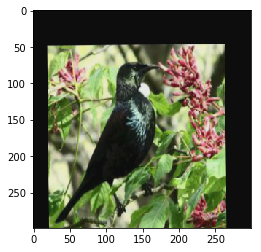

In [21]:
# take a look at the first augmented image in the set
#for (i, data) in enumerate(images_aug):
aug_img = Image.fromarray(images_aug[0],"RGB")
plt.imshow(aug_img)

In [22]:
print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status == "Training"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# The iteration is now trained. Make it the default project endpoint
trainer.update_iteration(project.id, iteration.id, is_default=True)
iteration_id = iteration.id
print ("Done!")

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Done!


In [23]:
testFileName = img_dir+sep+'test.jpg'
test_img_url = 'https://assets.saatchiart.com/saatchi/115660/art/1395178/665832-8.jpg'
with urllib.request.urlopen(test_img_url) as response, open(testFileName, 'wb') as out_file:
        data = response.read() # a `bytes` object
        out_file.write(data)
        
resize_eq(testFileName)

In [24]:
# Now there is a trained endpoint that can be used to make a prediction
predictor = prediction_endpoint.PredictionEndpoint(prediction_key)

# Open the sample image and get back the prediction results.
with open(testFileName, mode="rb") as test_data:
    results = predictor.predict_image(project_id, test_data.read(), iteration_id)

# Display the results.
for prediction in results.predictions:
    print ("\t" + prediction.tag + ": {0:.2f}%".format(prediction.probability * 100))

	fantail: 99.99%
	tui: 1.56%
	kea: 0.11%
	kiwi: 0.05%
	kokako: 0.01%
	kakapo: 0.00%
	kaka: 0.00%
	cockatoo: 0.00%
	morepork: 0.00%


In [25]:
y_actu = []
y_pred = []
miscalc = 0

for (i, data) in enumerate(testData):
    tagname = le.classes_[testLabels[i]]
    imagePath = test_dir+sep+tagname+sep+uuid.uuid4().hex+".jpg"
    out = Image.fromarray(data.reshape(final_dim,final_dim,3),"RGB").save(imagePath)
    with open(os.fsdecode(imagePath), mode="rb") as img_data: 
        results = predictor.predict_image(project_id, img_data.read(), iteration_id)
        y_pred.append(le.classes_.tolist().index(results.predictions[0].tag))
        y_actu.append(testLabels[i])
        if (results.predictions[0].tag!=tagname):
            miscalc = miscalc+1
        
    #if os.path.isfile(imagePath):
    #    os.remove(imagePath)
        
    # show an update every 100 images
    if i > 0 and i % 100 == 0:
        #print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        print("[INFO] processed {}/{}".format(i, len(testData)))

print(miscalc)
print(1-(miscalc/len(testData)))

[INFO] processed 100/135
6
0.9555555555555556


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

   cockatoo       0.87      1.00      0.93        13
    fantail       1.00      1.00      1.00        19
       kaka       0.86      1.00      0.92        12
     kakapo       0.89      0.89      0.89         9
        kea       1.00      0.86      0.92        14
       kiwi       1.00      1.00      1.00        17
     kokako       0.92      0.92      0.92        13
   morepork       1.00      0.96      0.98        25
        tui       1.00      0.92      0.96        13

avg / total       0.96      0.96      0.96       135

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.11 0.   0.   0.89 0.   0.   0.   0.   0.  ]
 [0.   0.   0.14 0.   0.86 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.08 0.   0.   0.   0.   0.   0.92 0.   0.  ]
 [0.   0.   0.   0.04 0.   0.   0.   0.96 0.  ]
 [

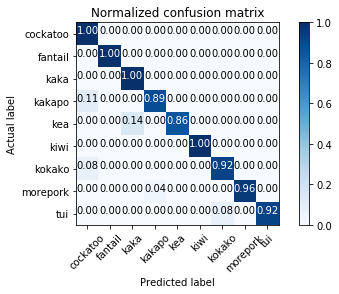

In [27]:
print(classification_report(y_actu, y_pred, target_names=le.classes_))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_actu, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [28]:
#https://docs.microsoft.com/en-us/python/api/azure.cognitiveservices.vision.customvision?view=azure-python
    
modelNm = uuid.uuid4().hex+".mlmodel"
exports = trainer.get_exports(project_id, iteration_id)

if (len(exports)==0):
    # no model has been exported yet we need to export a coreml model.
    print("Building CoreML Model")
    trainer.export_iteration(project_id, iteration_id, 'CoreML')
    exports = trainer.get_exports(project_id, iteration_id)

for (i, export) in enumerate(exports):
    if(export.status=='Done'):
        if(export.platform=='CoreML'):
            print('writing file {}'.format(model_dir+sep+modelNm))
            with urllib.request.urlopen(export.download_uri) as response, open(model_dir+sep+modelNm, 'wb') as out_file:
                data = response.read() # a `bytes` object
                out_file.write(data)

Building CoreML Model
writing file data\anzbirds_images_test_train\model\7b91ed5c25fa4e998b08079a0ac56879.mlmodel


mkdir coremltools

git clone --recursive https://github.com/apple/coremltools.git

pip install -e coremltools/

pip install -U winmltools

In [29]:
# Load model file
model_coreml = load_spec(model_dir+sep+modelNm)

# Convert it!
# The automatic code generator (mlgen) uses the name parameter to generate class names.
model_onnx = convert_coreml(model_coreml, name=projectName+'Model')

# Save the produced ONNX model in binary format
print('writing file {}'.format(model_dir+sep+modelNm.replace(".mlmodel", ".onnx")))
save_model(model_onnx, model_dir+sep+modelNm.replace(".mlmodel", ".onnx"))

writing file data\anzbirds_images_test_train\model\7b91ed5c25fa4e998b08079a0ac56879.onnx
